In [159]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [160]:
def get_data():
    x_train_ = pd.read_csv('X_train.csv')
    y_train_ = pd.read_csv('y_train.csv').drop('id', axis=1)
    x_test_ = pd.read_csv('X_test.csv').drop('id', axis=1)
    return x_train_, y_train_, x_test_

In [161]:
def outlier_detection_gmm(x_train, y, dimensions, percentile=5, plot=False):

    # extract Principle Components
    pca = PCA(n_components=dimensions, random_state=42)

    # pca.fit already returns data projected on lower dimensions
    pi = pca.fit_transform(x_train)

    # Fit Gaussian Mixture Model
    gm = GaussianMixture(n_components=1, random_state=42).fit(pi)

    # compute probability of each sample belonging to the GMM
    densities = gm.score_samples(pi)

    # set a density threshold to 4th percentile of the overall density distribution
    # check (https://en.wikipedia.org/wiki/Percentile) for percentile definition
    density_threshold = np.percentile(densities, percentile)

    # remove anomalies from pi
    pi_new = pi[densities >= density_threshold]

    # remove anomalies from x_train & y
    x_train = x_train[densities >= density_threshold]
    y = y[densities >= density_threshold]

    # print number of outliers
    outliers = pi[densities < density_threshold]
    print(outliers)
    print(f"Outlier Detection: \r\n {outliers.shape[0]} outliers have been found and removed")

    return x_train, y


def fill_nan(x_train_, y_train_):
    x_train_['label'] = y_train_['y']
    x_train_ = x_train_.sort_values(by=['label'])
    x_train_ = x_train_.fillna(method='ffill')
    x_train_ = x_train_.fillna(method='bfill')
    x_train_ = x_train_.drop('label', axis=1)
    x_train_ = x_train_.sort_values(by=['id'])
    x_train_ = x_train_.drop('id', axis=1)
    return x_train_


In [162]:
def remove_std_zero_features(x_train_, x_test_):
    zero_std = (x_train_.std() > 0.0)
    print("we remove ", x_train_.shape[1] - zero_std.sum(), "features which have std_deviation == 0")
    x_train_ = x_train_.loc[:, zero_std]
    x_test_ = x_test_.loc[:, zero_std]
    return x_train_, x_test_


def remove_uniform_features(x_train_, x_test_):
    x = x_train_.to_numpy()
    chi_test = np.zeros(x.shape[1])  # stores a 1 if the feature is uniform like

    # does the xhi_squared test for each feature and stores a 1 in test if p_value > 0.05
    for i in range(x.shape[1]):
        hist = np.histogram(x[:, i], bins=20)[0]
        hist = np.delete(hist, hist.argmax())
        unif = np.ones_like(hist) * hist.sum() / hist.shape
        if chisquare(hist, unif).pvalue > 0.05:
            chi_test[i] = 1

    print("we remove ", chi_test.sum(), "uniform looking features")
    unif_cols_indicies = chi_test.nonzero()[0]  # indices of uniform features
    unif_cols_names = x_train_.columns[unif_cols_indicies]  # data frame column names of uniform features
    x_train_ = x_train_.drop(unif_cols_names, axis=1)  # drops these columns
    x_test_ = x_test_.drop(unif_cols_names, axis=1)

    return x_train_, x_test_


# Rad in data

In [163]:
x_train, y_train, x_test = get_data()

## Missing Values
-for each feature we have less then 10% missing values

In [164]:
# replace missing values
x_train= fill_nan(x_train,y_train)
x_test = x_test.fillna(x_test.median())

## Center data

In [31]:
def center_data(x_data_):
    x_centered = x_data_.apply(lambda x: x - x.mean())
    return x_centered

In [32]:
x_train = center_data(x_train)
x_test = center_data(x_test)

In [157]:
y_train

,y
0,74.0
1,51.0
2,70.0
3,52.0
4,85.0
...,...
1207,70.0
1208,86.0
1209,68.0
1210,71.0


# Visualize features

## Describe statistics

In [34]:
x_train.iloc[:,100:110].describe()

,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109
count,1.212000e+03,1.212000e+03,1.212000e+03,1.212000e+03,1212.0,1.212000e+03,1.212000e+03,1.212000e+03,1.212000e+03,1.212000e+03
mean,-1.193149e-13,-6.648616e-13,-1.608688e-13,-4.178273e-12,0.0,1.115353e-15,-1.208157e-13,-3.121815e-16,-1.729456e-16,-3.887114e-13
std,4.251798e+02,8.634024e+02,2.855632e+01,1.014276e+04,0.0,2.816486e-01,1.011621e+02,1.826888e-01,1.011240e+00,2.785496e+02
min,-1.173644e+03,-3.572379e+03,-5.012979e+01,-3.531591e+04,0.0,-5.337730e-01,-3.067712e+02,-7.039693e-01,-3.271587e+00,-5.053039e+02
25%,-2.881992e+02,-5.102265e+02,-2.384063e+01,-6.483664e+03,0.0,-2.269562e-01,-6.423905e+01,-1.101655e-01,-6.899095e-01,-2.231189e+02
50%,-2.594033e+01,-4.618067e+01,5.021249e-01,-7.481354e+01,0.0,-6.790335e-03,-2.461184e+00,1.137889e-02,4.928029e-02,1.307100e+00
75%,2.550435e+02,5.277881e+02,2.493544e+01,6.160239e+03,0.0,2.318533e-01,6.744333e+01,1.135549e-01,6.778824e-01,2.301669e+02
max,1.744539e+03,4.570768e+03,4.929400e+01,3.212192e+04,0.0,5.410125e-01,3.995117e+02,6.402932e-01,3.040315e+00,4.910979e+02


## Boxplots

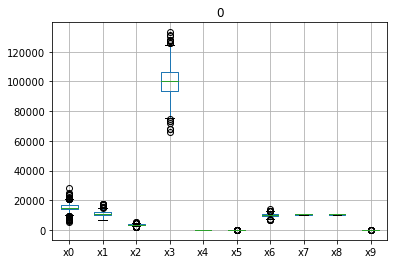

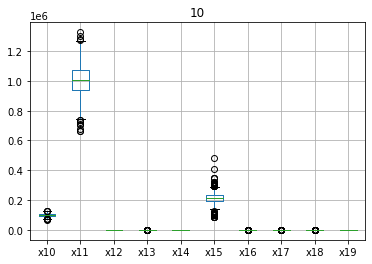

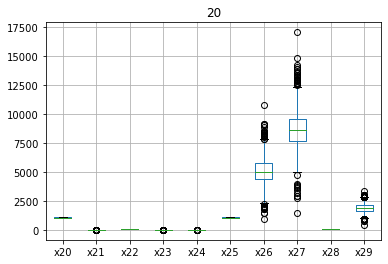

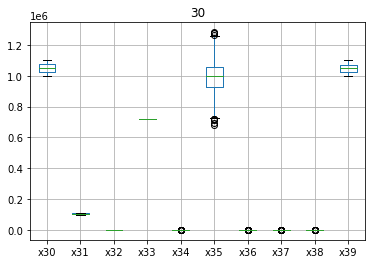

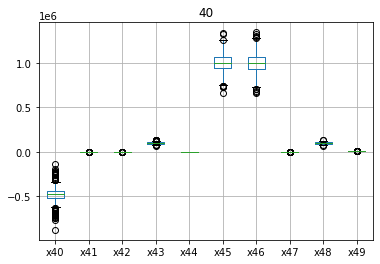

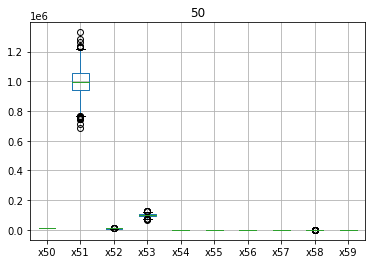

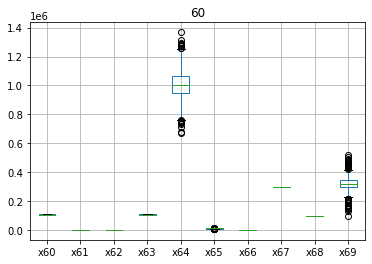

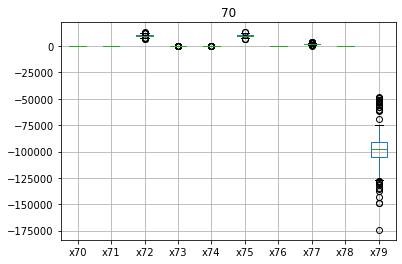

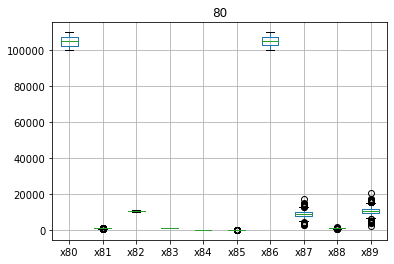

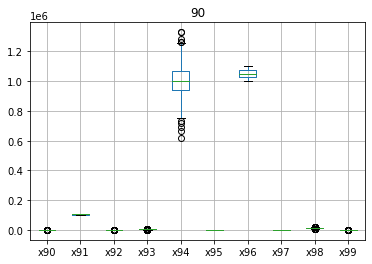

In [152]:
#boxplot of featues
for i in range(10):
    plt.figure()
    plt.title(i*10)
    x_train.iloc[:, i*10:(i+1)*10].boxplot()

## Histograms

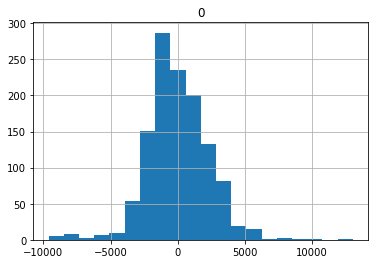

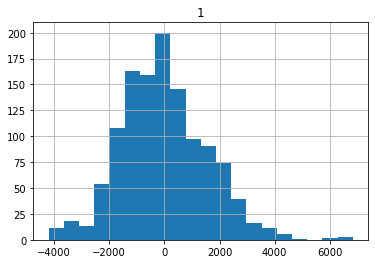

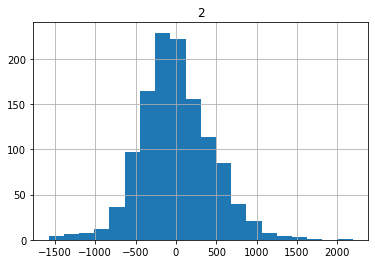

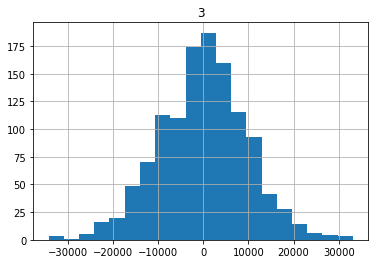

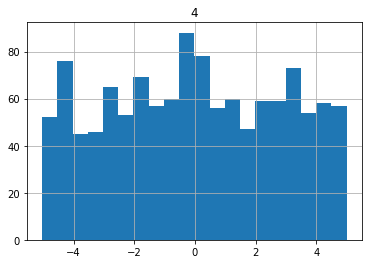

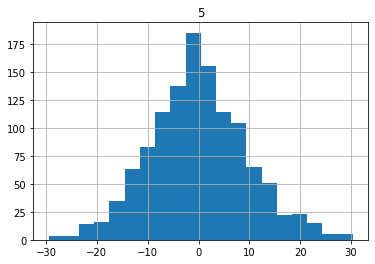

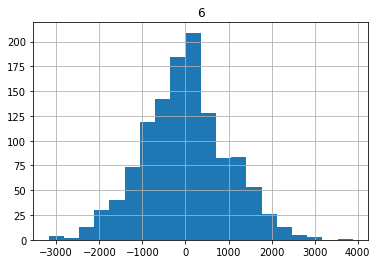

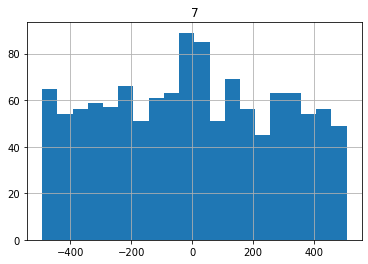

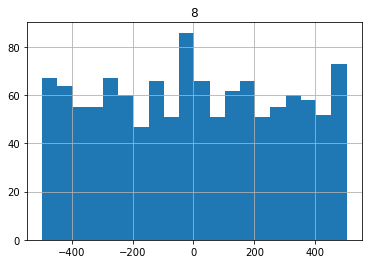

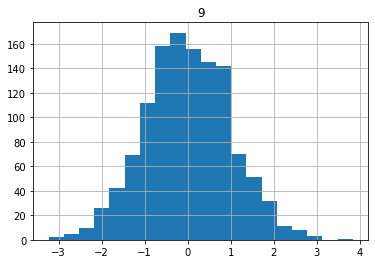

In [36]:
#histogram plot of features
for i in range(10):
    plt.figure()
    plt.title(i)
    x_train.iloc[:,i].hist(bins = 20)

## label histogram

'\ny = y_train.to_numpy().reshape(-1)\ny_hist = np.histogram(y, bins = 55)\ny_hist\n'

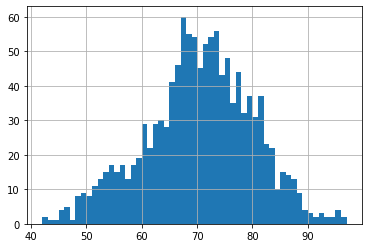

In [37]:
# age distribution of the training set 
# --> should we do something to balance this?
y_train['y'].hist(bins=55)

# histogram arrray:
'''
y = y_train.to_numpy().reshape(-1)
y_hist = np.histogram(y, bins = 55)
y_hist
'''

## plot two features

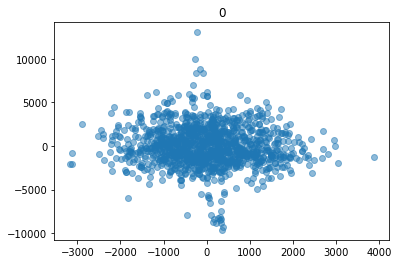

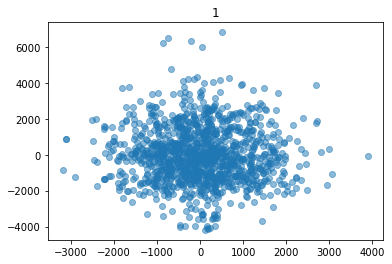

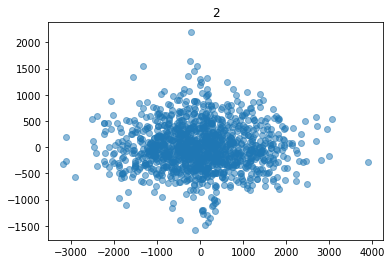

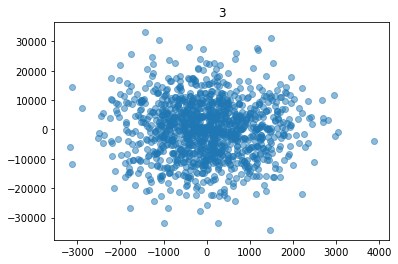

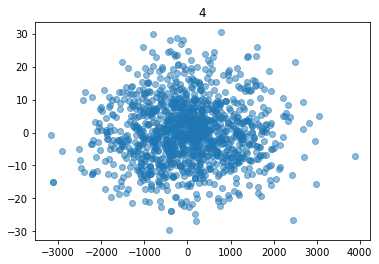

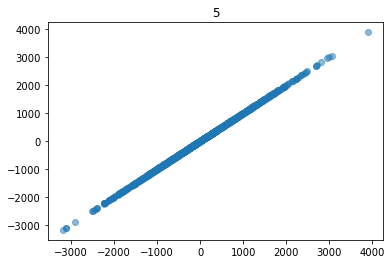

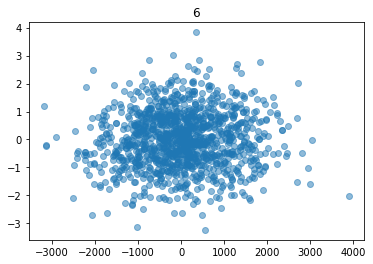

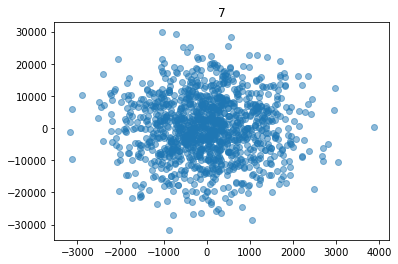

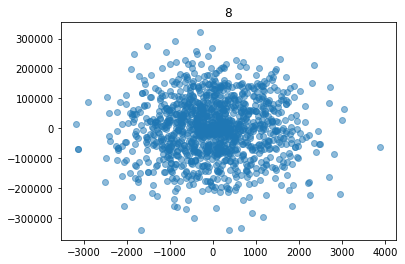

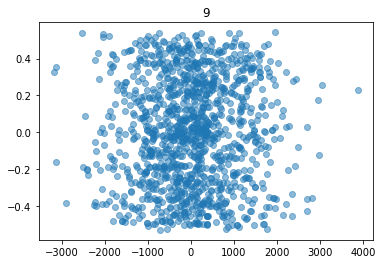

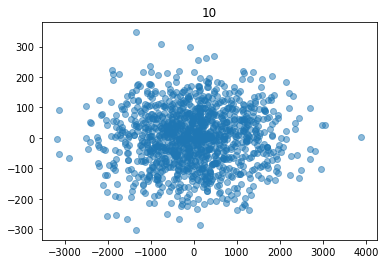

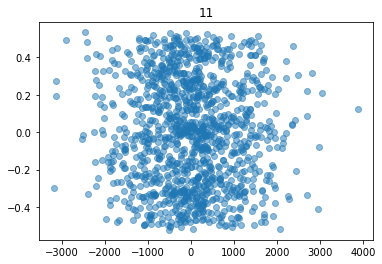

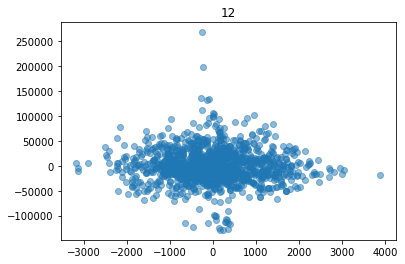

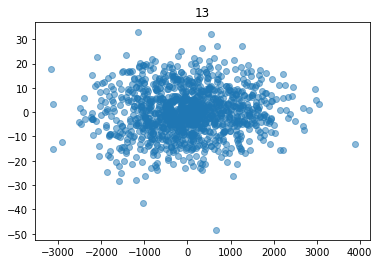

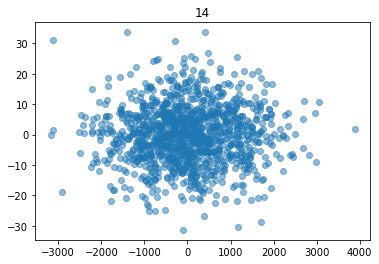

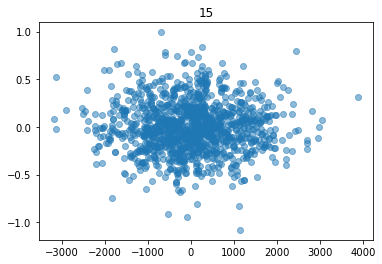

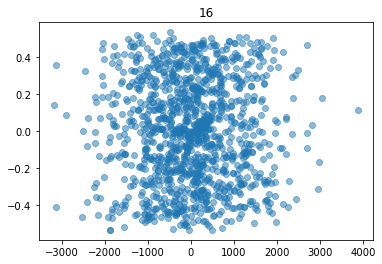

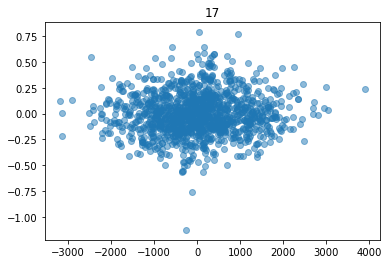

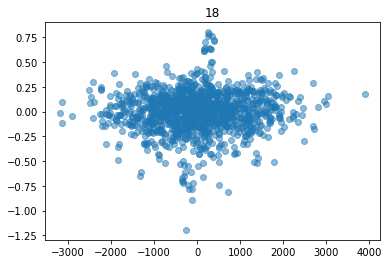

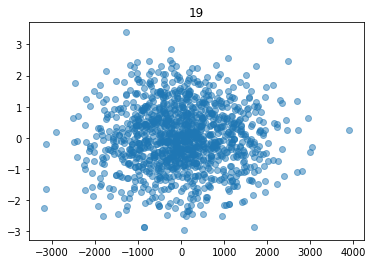

In [113]:
for i in range(20):
    plt.figure()
    plt.title(i)
    plt.scatter(x_train.iloc[:,5], x_train.iloc[:,i], alpha=.5)
    plt.show()

## Remove naive features

In [166]:
x_train, x_test = remove_std_zero_features(x_train, x_test)  # remove features with zero std_deviation
x_train, x_test = remove_uniform_features(x_train, x_test)  # remove features with uniform distribution

we remove  4 features which have std_deviation == 0
we remove  215.0 uniform looking features


# Outlier detection

In [168]:
def standardization(x_data_):
    scaler_ = StandardScaler().fit(x_data_)
    x_data_ = scaler_.transform(x_data_)
    return x_data_

In [169]:
x_train = standardization(x_train)
x_test = standardization(x_test)

## PCA

## plot label vs feature

In [17]:
x_removed, y_removed = outlier_detection_gmm(x_train, y_train, 50)

[[ 1.80521248e+22  3.74426628e+22 -1.56450933e+13 ... -1.05707046e+07
  -4.47184790e+06  4.71842594e+06]
 [-4.39070540e+22 -2.96790735e+20  3.62634155e+13 ...  5.86662903e+06
   1.08067463e+07 -7.88533825e+06]
 [ 3.33277511e+22  3.29868796e+22  9.92481852e+13 ... -2.97747346e+05
  -2.83136669e+06 -2.01992717e+06]
 ...
 [ 1.36200488e+23  3.96590043e+22 -4.46571872e+12 ...  6.49975646e+06
  -3.14064365e+06 -2.59788345e+06]
 [-1.14282382e+23 -6.33847713e+20  2.50776817e+14 ... -1.32977165e+05
   1.69944722e+05 -9.50325639e+05]
 [ 2.85105157e+22  1.22217779e+22 -3.09216272e+14 ... -1.22916924e+07
  -9.45450641e+06  1.05670126e+06]]
Outlier Detection: 
 61 outliers have been found and removed


In [18]:
x_train.shape

(1212, 613)

In [19]:
x_removed.shape

(1151, 613)

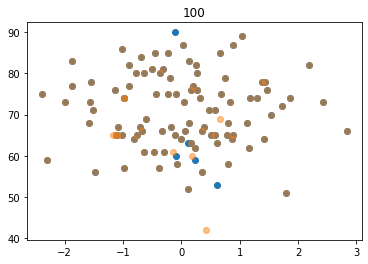

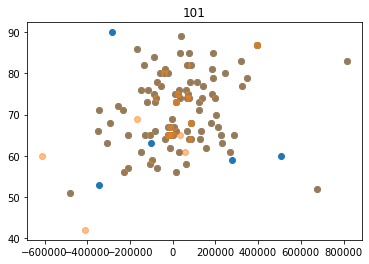

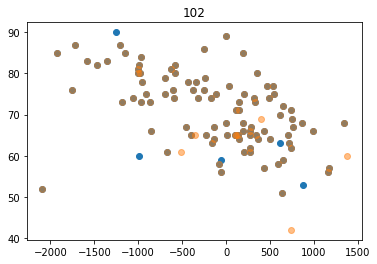

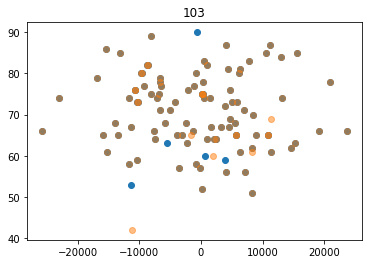

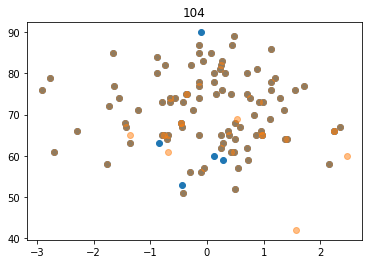

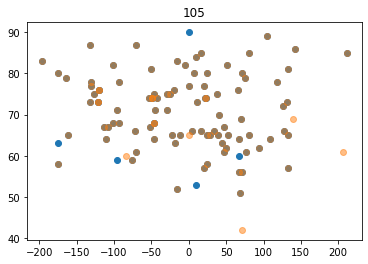

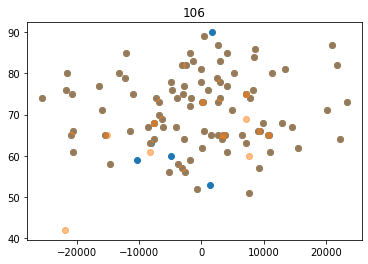

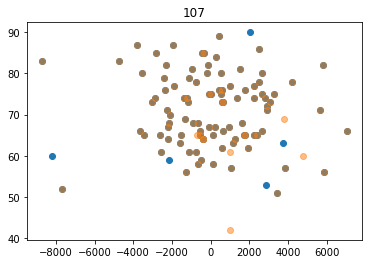

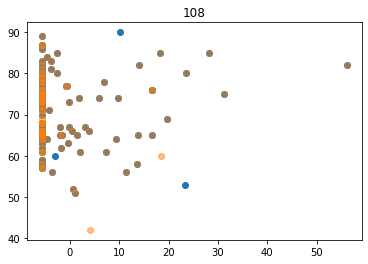

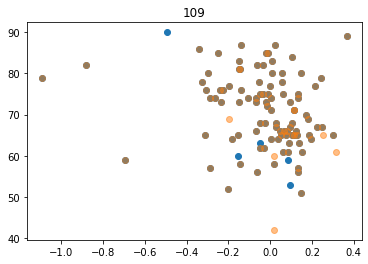

In [20]:
for i in range(100,110):
    plt.figure()
    plt.title(i)
    plt.scatter(x_train.iloc[:100,i], y_train.to_numpy()[:100])
    plt.scatter(x_removed.iloc[:100,i], y_removed.to_numpy()[:100], alpha=.5)
    plt.show()

In [216]:
def pca_reduction(x_train_, x_test_, dimensions):
    # extract Principle Components
    pca = PCA(n_components=dimensions, svd_solver='full')
    # pca.fit already returns data projected on lower dimensions
    return pca.fit_transform(x_train_), pca.fit_transform(x_test_)